# Importation

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp
import yaml

import qubic
from qubic.lib.MapMaking.Qatmosphere_2d import AtmosphereMaps
from qubic.lib.Instrument.Qacquisition import QubicAcquisition
from qubic.lib.Instrument.Qinstrument import QubicInstrument
from qubic.lib.Qscene import QubicScene
from qubic.lib.Qsamplings import get_pointing, equ2gal, QubicSampling

from qubic.lib.MapMaking.Qcg import PCGAlgorithm
from pyoperators.iterative.core import AbnormalStopIteration

from pyoperators import MPI, BlockDiagonalOperator, DiagonalOperator, ReshapeOperator

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

%matplotlib inline

# Atm class

In [2]:
# Import simulation parameters
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 

In [3]:
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)
qubic_dict = atm.qubic_dict

500


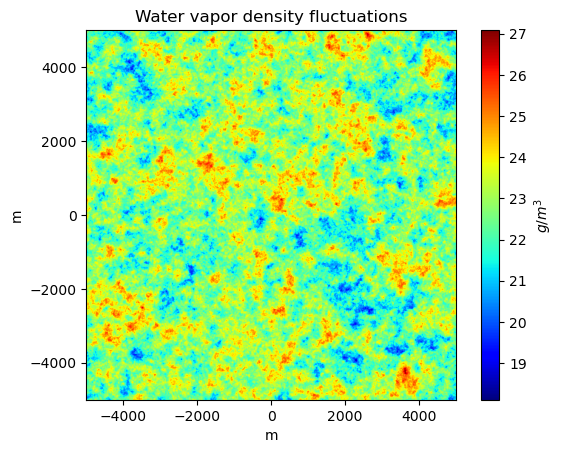

In [4]:
wv_fluctuations = atm.rho_map
print(wv_fluctuations.shape[0])
plt.imshow(wv_fluctuations, cmap='jet', extent=[-params['size_atm'], params['size_atm'], -params['size_atm'], params['size_atm']])
plt.title('Water vapor density fluctuations')
plt.xlabel('m')
plt.ylabel('m')
plt.colorbar(label=r'$g/m^{3}$')

In [5]:
print("Frequencies are : ", atm.frequencies, "GHz.")

Frequencies are :  [135.50540829 144.29216391 153.6486907  163.61193508 198.74126549
 211.62850707 225.35141303 239.96417145] GHz.


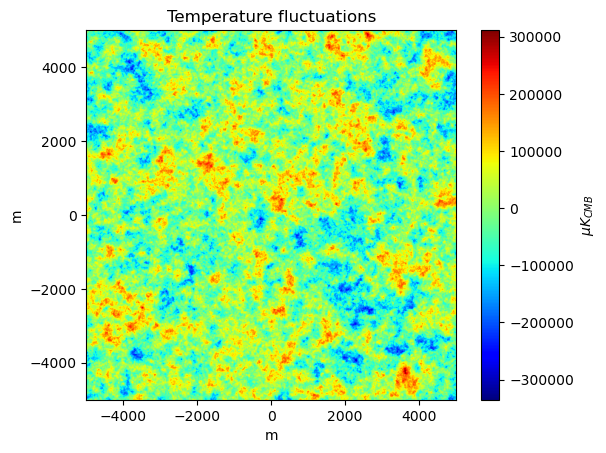

In [6]:
temp_fluctuations = np.zeros((wv_fluctuations.shape[0], wv_fluctuations.shape[1], 3))
temp_fluctuations[..., 0] = atm.get_temp_maps(wv_fluctuations)[0]
temp_fluctuations[..., 0] -= np.mean(temp_fluctuations[..., 0])

plt.imshow(temp_fluctuations[..., 0], cmap='jet', extent=[-params['size_atm'], params['size_atm'], -params['size_atm'], params['size_atm']])
plt.title('Temperature fluctuations')
plt.xlabel('m')
plt.ylabel('m')
plt.colorbar(label=r'$\mu K_{CMB}$')

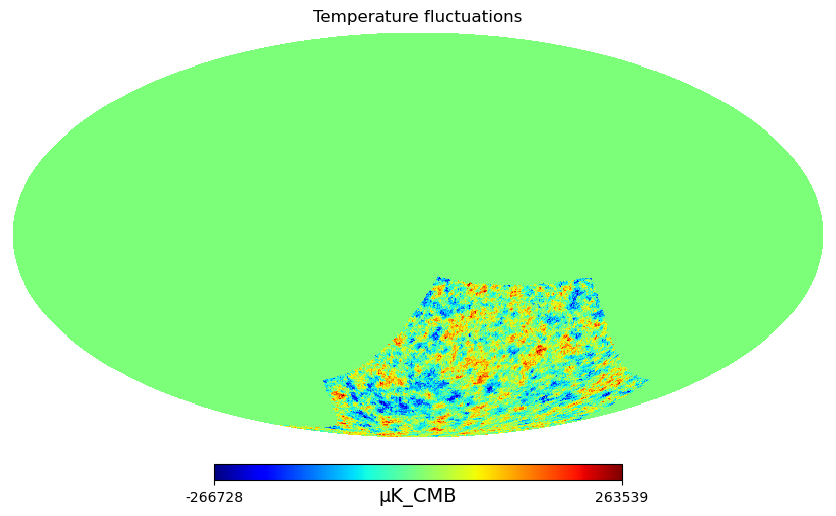

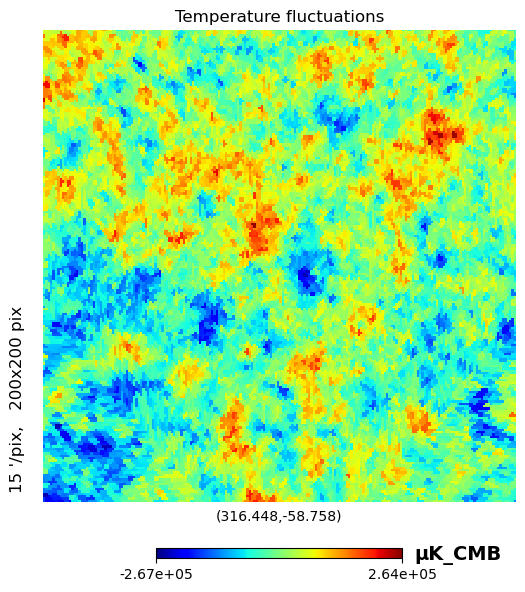

In [7]:
healpy_temp_fluctuations = np.zeros((hp.nside2npix(params['nside']), 3))
healpy_temp_fluctuations[..., 0] = atm.get_healpy_atm_maps_2d(atm.get_temp_maps(wv_fluctuations))[0]

index = np.where(healpy_temp_fluctuations!=0)[0]
healpy_temp_fluctuations[index, 0] -= np.mean(healpy_temp_fluctuations[index, 0])
min = np.min(healpy_temp_fluctuations[index, 0])
max = np.max(healpy_temp_fluctuations[index, 0])

hp.mollview(healpy_temp_fluctuations[..., 0], min=min, max=max, cmap='jet', title='Temperature fluctuations', unit='µK_CMB')
hp.gnomview(healpy_temp_fluctuations[..., 0], min=min, max=max, rot=equ2gal(0, -57), reso=15, cmap='jet', title='Temperature fluctuations', unit='µK_CMB')

# Build MM

In [8]:
q_instrument = QubicInstrument(qubic_dict)
q_scene = QubicScene(qubic_dict)
q_sampling = get_pointing(qubic_dict)

q_acquisition = QubicAcquisition(q_instrument, q_sampling, q_scene, qubic_dict)

You asked 5000 pointings with repeat strategy so I will provide 1666 pointings repeated 3 times.


In [9]:
coverage = q_acquisition.get_coverage()

covnorm = coverage / coverage.max()
seenpix = covnorm > params['coverage_cut']

center = np.array([0, -57])
qubic_patch = qubic.lib.Qsamplings.equ2gal(center[0], center[1])

Info DESKTOP-5T6UOML: Allocating (4958016,9) elements = 680.8798828125 MiB in FSRRotation3dMatrix.__init__.


In [10]:
H_qubic = q_acquisition.get_operator()
R_qubic = ReshapeOperator(H_qubic.shapeout, H_qubic.shape[0])
invN_qubic = R_qubic(q_acquisition.get_invntt_operator(False, False)(R_qubic.T))
d_qubic = H_qubic(healpy_temp_fluctuations).ravel()

Info DESKTOP-5T6UOML: Allocating (4958016,9) elements = 680.8798828125 MiB in FSRRotation3dMatrix.__init__.


In [11]:
H = R_qubic(H_qubic)
invN = invN_qubic
d = d_qubic

In [12]:
A = H.T * invN * H
b = H.T * invN * d.flatten()
x0 = healpy_temp_fluctuations*0
true_maps = healpy_temp_fluctuations

In [13]:
stacked_dptdp_inv = np.zeros((1,12*params['nside']**2))

D = H.operands[2]
P = H.operands[-1]
sh = P.matrix.data.index.shape
no_det = 992
point_per_det = int(sh[0] / no_det)
mapPtP_perdet_seq = np.zeros((no_det, 12 * params['nside']**2))
sample_ranges = [(det * point_per_det, (det + 1) * point_per_det) for det in range(no_det)]
for det, (start, end) in enumerate(sample_ranges):
    indices = P.matrix.data.index[start:end, :]  
    weights = P.matrix.data.r11[start:end, :]
    flat_indices = indices.ravel()
    flat_weights = weights.ravel()

    mapPitPi = np.zeros(12 * params['nside']**2)
    np.add.at(mapPitPi, flat_indices, flat_weights**2)

    mapPtP_perdet_seq[det, :] = mapPitPi
D_elements = D.data
D_sq = D_elements**2
mapPtP_seq_scaled = D_sq[:, np.newaxis] * mapPtP_perdet_seq 
dptdp = mapPtP_seq_scaled.sum(axis = 0)
dptdp_inv = 1 / dptdp
dptdp_inv[np.isinf(dptdp_inv)] = 0.
stacked_dptdp_inv[0] = dptdp_inv
M = BlockDiagonalOperator([DiagonalOperator(ci, broadcast='rightward') for ci in stacked_dptdp_inv],  new_axisin=0)

# Map-Making

In [14]:
# Run PCG
algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-10,
    maxiter=200,
    disp=True,
    M=M,
    center=[0, -57],
    reso=15,
    seenpix=seenpix,
    input=true_maps,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

 Iter     Tol      time
   1: 4.9820e-01 0.31868 [11640.34801249  6043.76432244 26501.14806797 ...  8636.56181209
 12652.52585279 18405.719316  ]
   2: 1.9018e-01 0.32370 [10203.6352071   7444.42801597  9410.9201127  ... 10980.46860903
  1469.03663846  4253.7767218 ]
   3: 1.3004e-01 0.32787 [ 8896.06414785  5012.03130486  8144.26742629 ... 13541.87576086
  4593.45500373  1764.30881934]
   4: 7.3791e-02 0.31299 [2356.59322115 1148.91773388 8219.35177253 ... 9115.41348926 4264.62093599
  423.00483495]
   5: 3.6815e-02 0.32081 [ 2740.60500304  4657.53685701  6571.02486287 ... 12572.0006356
 10111.15176588  6323.05423621]
   6: 2.2100e-02 0.31999 [ 3432.00849167  2686.73621361   903.00163759 ... 12026.83791166
 10607.90133412  9779.06103307]
   7: 1.7802e-02 0.33548 [3067.13104568 1532.49957084  350.55493588 ... 8575.88055789 7309.68300535
 8109.24769384]
   8: 1.3778e-02 0.32733 [1134.89524869 2881.26301018 3993.93376461 ... 6744.88261541 6349.19772771
 5311.90903919]
   9: 1.7175e-02 0.

Text(0, 0.5, 'Convergence')

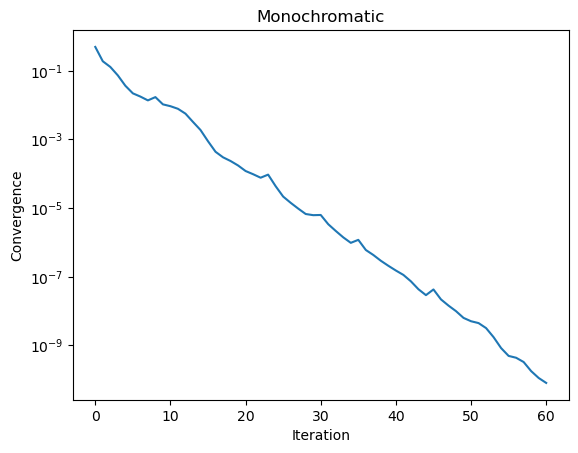

In [15]:
plt.plot(output['convergence'])
plt.title("Monochromatic")
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Convergence')

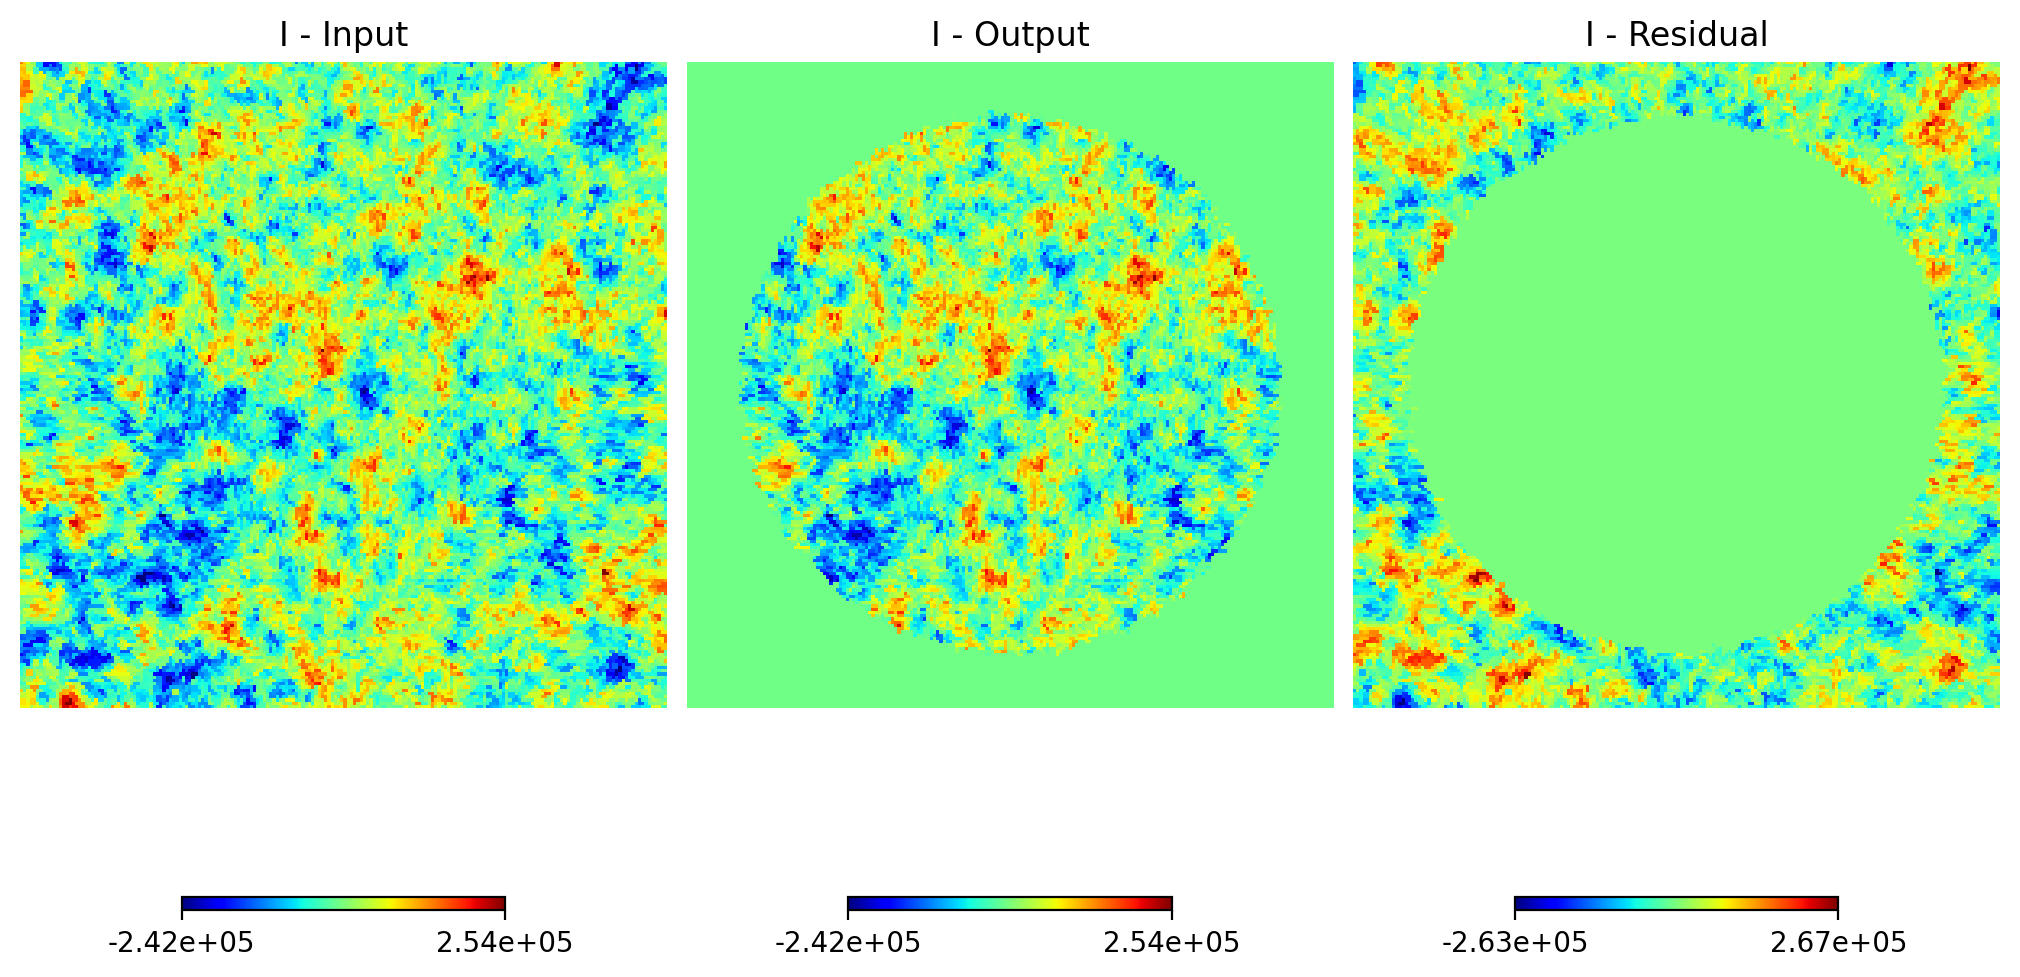

In [16]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
# true_maps[~seenpix, :] = hp.UNSEEN
# output['x'][~seenpix, :] = hp.UNSEEN
stk = ['I', 'Q', 'U']
istk = 0  
n_sig = 3
reso = 25

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=reso, sub=(1, 3, k), title=f'{stk[istk]} - Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=reso, sub=(1, 3, k+1), title=f'{stk[istk]} - Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=reso, sub=(1, 3, k+2), title=f'{stk[istk]} - Residual', notext=True)
k+=3

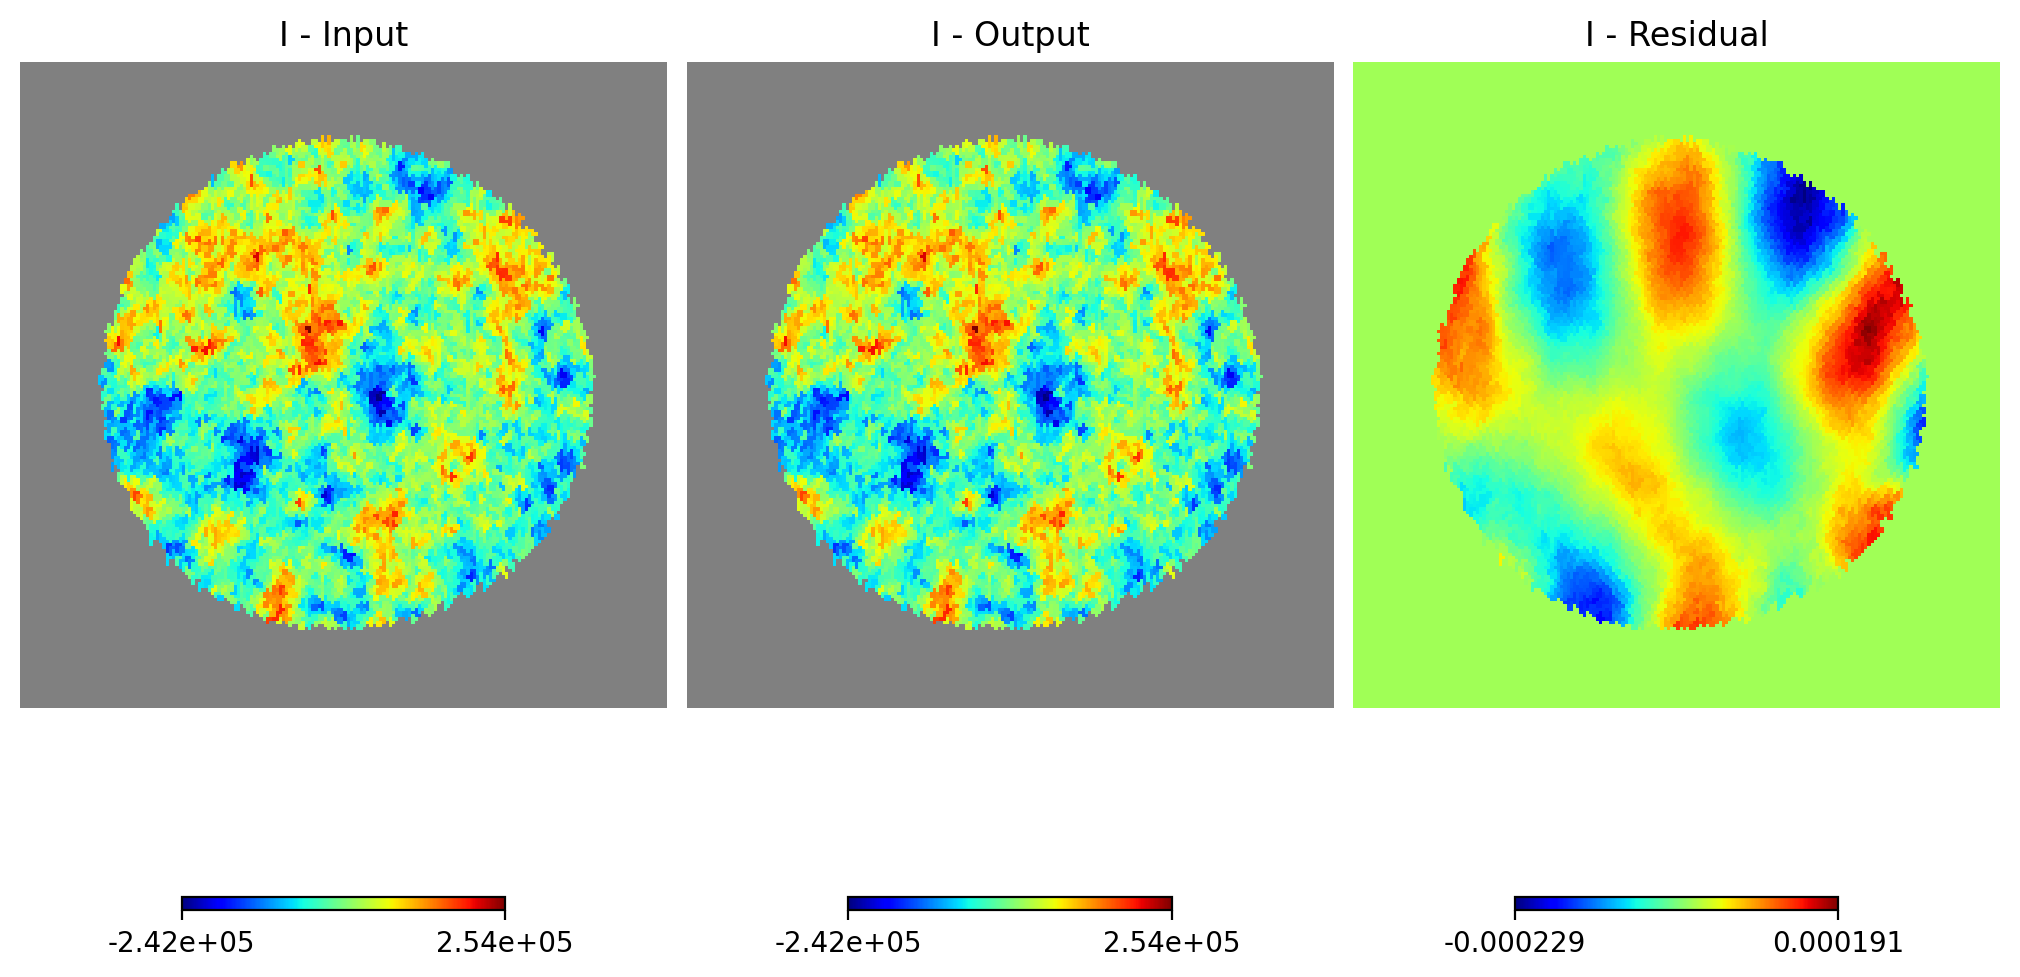

In [17]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN
stk = ['I', 'Q', 'U']
istk = 0  
n_sig = 3
reso = 15

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=reso, sub=(1, 3, k), title=f'{stk[istk]} - Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=reso, sub=(1, 3, k+1), title=f'{stk[istk]} - Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=reso, sub=(1, 3, k+2), title=f'{stk[istk]} - Residual', notext=True)
k+=3

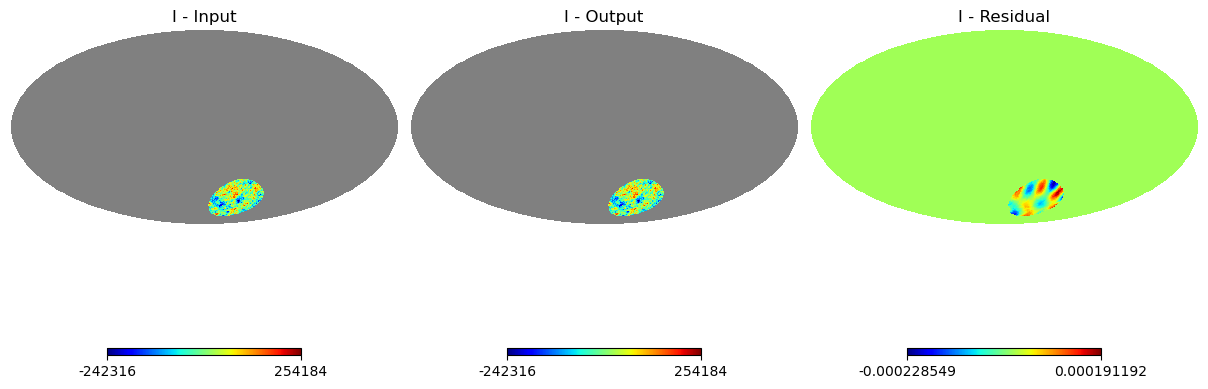

In [18]:
plt.figure(figsize=(12, 25))
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.mollview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k), title=f'{stk[istk]} - Input', notext=True)
hp.mollview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k+1), title=f'{stk[istk]} - Output', notext=True)
hp.mollview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', sub=(1, 3, k+2), title=f'{stk[istk]} - Residual', notext=True)
k+=3

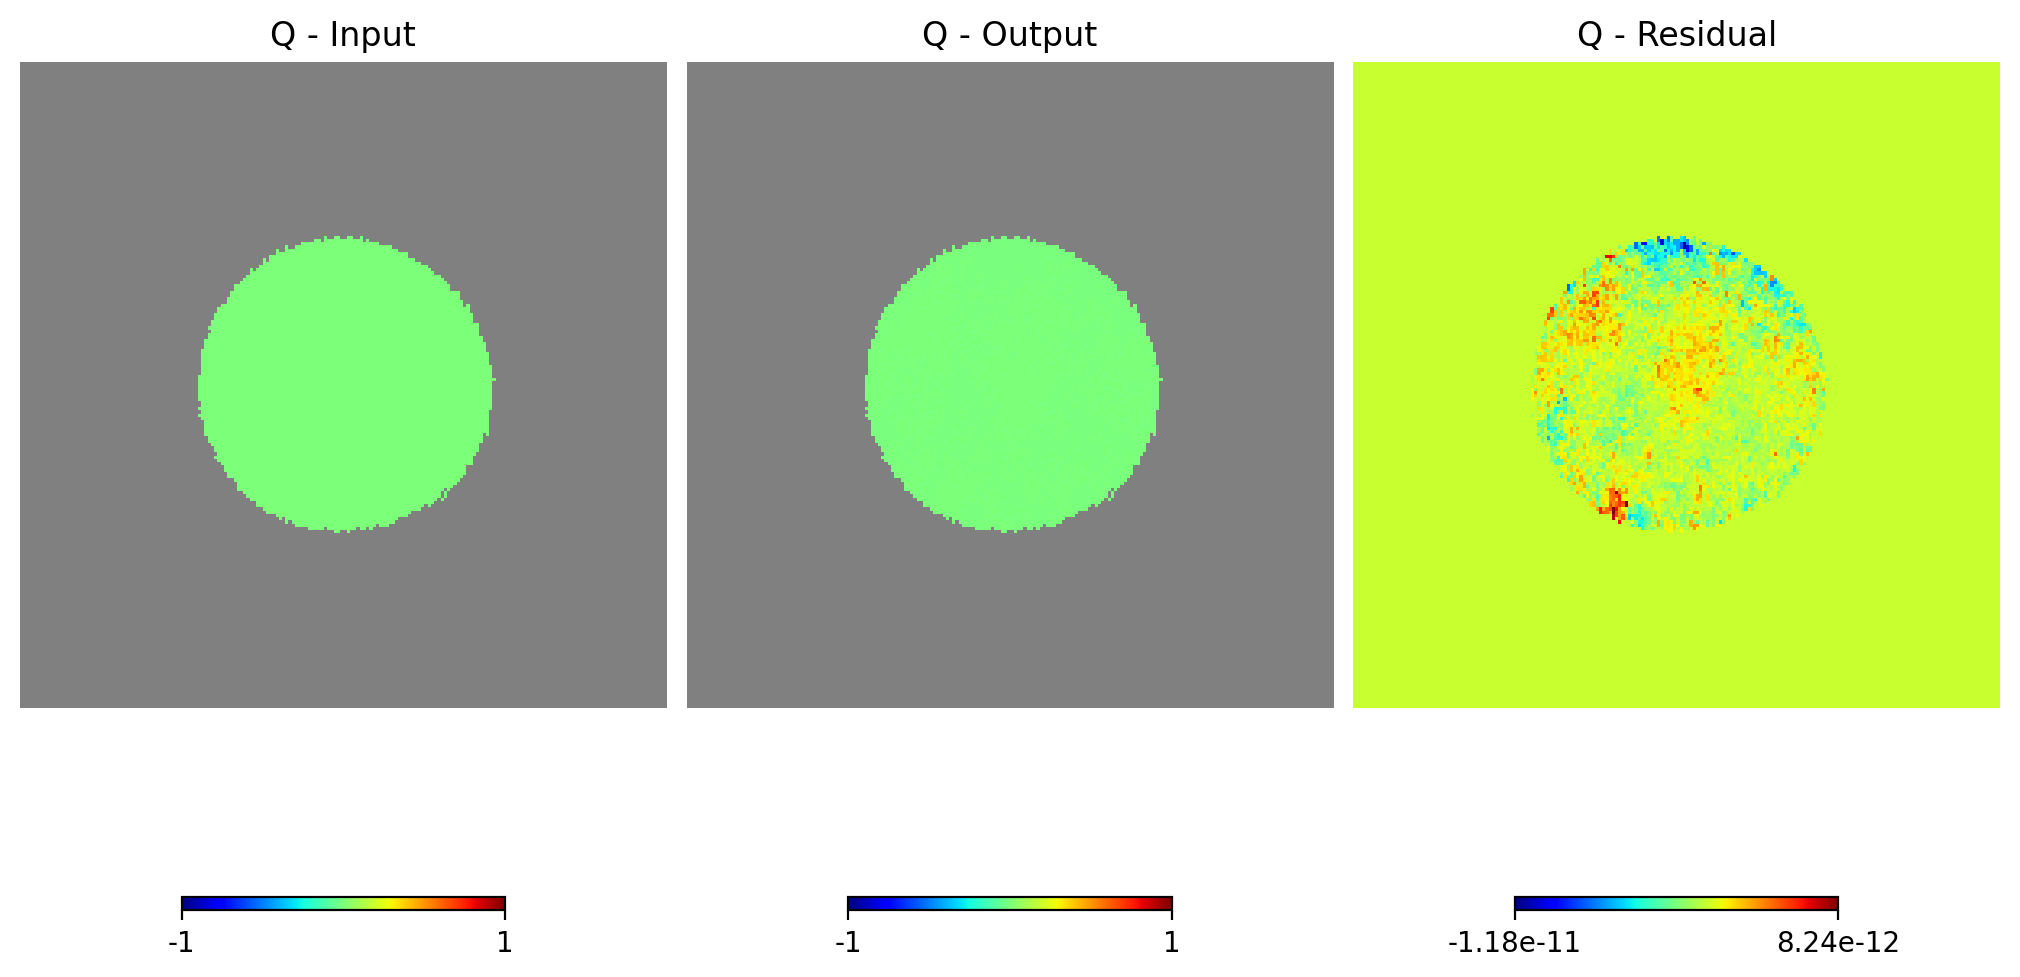

In [19]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 1
n_sig = 3
reso = 25

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=reso, sub=(1, 3, k), title=f'{stk[istk]} - Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=reso, sub=(1, 3, k+1), title=f'{stk[istk]} - Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=reso, sub=(1, 3, k+2), title=f'{stk[istk]} - Residual', notext=True)
k+=3